In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
# stk_path = "../../data/zz500.csv"
stk_path = "../../data/GSPC.csv"

test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                         # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0

model_seed = 100

fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [2]:
from xgboost import XGBRegressor

def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Load data

In [3]:
df = pd.read_csv(stk_path, sep = ",")

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head()

,date,open,high,low,close,adj_close,volume,month
0,2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,2090.110107,1466840000,11
1,2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,2080.409912,4275030000,11
2,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,2102.629883,3712120000,12
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,2079.510010,3950640000,12
4,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,2049.620117,4306490000,12


Text(0, 0.5, 'USD')

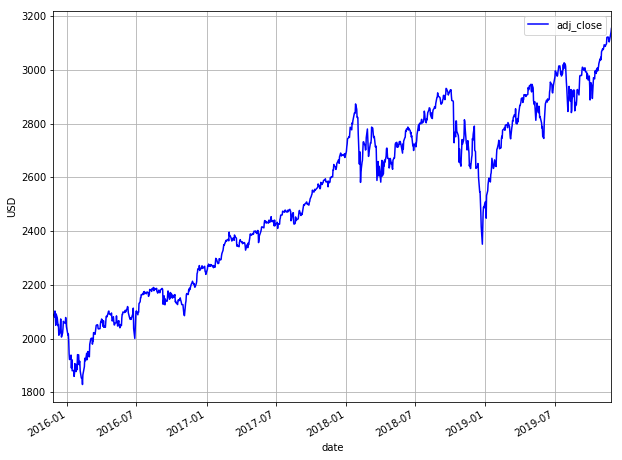

In [4]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Feature Engineering

We will generate the following features:
* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [5]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']
df.drop(['high', 'low'], axis=1, inplace=True)

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']
df.drop(['open', 'close'], axis=1, inplace=True)

df.head()

,date,adj_close,volume,month,range_hl,range_oc
0,2015-11-27,2090.110107,1466840000,11,9.160156,-1.290039
1,2015-11-30,2080.409912,4275030000,11,13.400147,10.540039
2,2015-12-01,2102.629883,3712120000,12,20.440185,-19.699951
3,2015-12-02,2079.510010,3950640000,12,27.159913,22.199951
4,2015-12-03,2049.620117,4306490000,12,42.650024,31.089844


Now we use lags up to N number of days to use as features.

In [6]:
# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']


In [7]:
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day
0,2015-11-27,2090.110107,1466840000,11,9.160156,-1.290039,0
1,2015-11-30,2080.409912,4275030000,11,13.400147,10.540039,1
2,2015-12-01,2102.629883,3712120000,12,20.440185,-19.699951,2
3,2015-12-02,2079.510010,3950640000,12,27.159913,22.199951,3
4,2015-12-03,2049.620117,4306490000,12,42.650024,31.089844,4


In [8]:
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

# Remove the first N rows which contain NaNs
df = df[N:]
    
df.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3
3,2015-12-02,2079.510010,3950640000,12,27.159913,22.199951,3,2102.629883,20.440185,-19.699951,3.712120e+09,2080.409912,13.400147,10.540039,4.275030e+09,2090.110107,9.160156,-1.290039,1.466840e+09
4,2015-12-03,2049.620117,4306490000,12,42.650024,31.089844,4,2079.510010,27.159913,22.199951,3.950640e+09,2102.629883,20.440185,-19.699951,3.712120e+09,2080.409912,13.400147,10.540039,4.275030e+09
5,2015-12-04,2091.689941,4214910000,12,42.600098,-40.449951,5,2049.620117,42.650024,31.089844,4.306490e+09,2079.510010,27.159913,22.199951,3.950640e+09,2102.629883,20.440185,-19.699951,3.712120e+09
6,2015-12-07,2077.070068,4043820000,12,23.639893,13.349854,6,2091.689941,42.600098,-40.449951,4.214910e+09,2049.620117,42.650024,31.089844,4.306490e+09,2079.510010,27.159913,22.199951,3.950640e+09
7,2015-12-08,2063.590088,4173570000,12,21.530030,9.799805,7,2077.070068,23.639893,13.349854,4.043820e+09,2091.689941,42.600098,-40.449951,4.214910e+09,2049.620117,42.650024,31.089844,4.306490e+09


In [9]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [10]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Get mean and std dev at timestamp t using values from t-1, ..., t-N

In [11]:
cols_list = [
"adj_close",
"range_hl",
"range_oc",
"volume"
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,date,adj_close,volume,month,range_hl,range_oc,order_day,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,...,range_oc_lag_3,volume_lag_3,adj_close_mean,adj_close_std,range_hl_mean,range_hl_std,range_oc_mean,range_oc_std,volume_mean,volume_std
3,2015-12-02,2079.510010,3950640000,12,27.159913,22.199951,3,2102.629883,20.440185,-19.699951,...,-1.290039,1.466840e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-03,2049.620117,4306490000,12,42.650024,31.089844,4,2079.510010,27.159913,22.199951,...,10.540039,4.275030e+09,2079.510010,NaN,27.159913,NaN,22.199951,NaN,3.950640e+09,NaN
5,2015-12-04,2091.689941,4214910000,12,42.600098,-40.449951,5,2049.620117,42.650024,31.089844,...,-19.699951,3.712120e+09,2064.565064,21.135346,34.904968,10.953163,26.644897,6.286104,4.128565e+09,2.516239e+08
6,2015-12-07,2077.070068,4043820000,12,23.639893,13.349854,6,2091.689941,42.600098,-40.449951,...,22.199951,3.950640e+09,2073.606689,21.647273,37.470012,8.928842,4.279948,38.991415,4.157347e+09,1.847768e+08
7,2015-12-08,2063.590088,4173570000,12,21.530030,9.799805,7,2077.070068,23.639893,13.349854,...,31.089844,4.306490e+09,2072.793375,21.358490,36.296672,10.961120,1.329916,37.253788,4.188407e+09,1.333255e+08


# Split into train, dev and test set

In [12]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 603
num_cv = 201
num_test = 201
train.shape = (603, 27)
cv.shape = (201, 27)
train_cv.shape = (804, 27)
test.shape = (201, 27)


# Scale the train, dev and test set

In [13]:
cols_to_scale = ["adj_close"]

for i in range(1, N+1):
    cols_to_scale.append("adj_close_lag_"+str(i))
    cols_to_scale.append("range_hl_lag_"+str(i))
    cols_to_scale.append("range_oc_lag_"+str(i))
    cols_to_scale.append("volume_lag_"+str(i))

# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))
print("train_scaled.shape = " + str(train_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[['date', 'month']] = train.reset_index()[['date', 'month']]
print("train_scaled.shape = " + str(train_scaled.shape))
train_scaled.head()

scaler.mean_ = [ 2.32195808e+03  2.32106791e+03  1.91857386e+01 -1.95641426e-01
  3.66931187e+09  2.32014892e+03  1.90981269e+01 -2.54845325e-01
  3.67025431e+09  2.31918677e+03  1.90720739e+01 -2.65458761e-01
  3.66768277e+09]
scaler.var_ = [6.10073836e+04 6.09192538e+04 2.18314143e+02 2.52920490e+02
 5.16100009e+17 6.08514755e+04 2.14691728e+02 2.49532221e+02
 5.16705246e+17 6.07349927e+04 2.14799585e+02 2.49486157e+02
 5.24043443e+17]
train_scaled.shape = (603, 13)
train_scaled.shape = (603, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-0.981584,-0.885016,0.084901,-1.226418,0.059588,-0.971859,-0.388878,0.683368,0.841343,-0.929526,-0.676302,-0.064867,-3.040223,2015-12-02,12
1,-1.102597,-0.978687,0.539691,1.408220,0.391603,-0.881783,0.091593,-1.230969,0.058242,-0.968886,-0.387003,0.684103,0.838983,2015-12-03,12
2,-0.932272,-1.099788,1.588058,1.967211,0.886939,-0.975507,0.550204,1.421497,0.390063,-0.878724,0.093348,-1.230410,0.061385,2015-12-04,12
3,-0.991463,-0.929340,1.584679,-2.531165,0.759462,-1.096675,1.607379,1.984269,0.885109,-0.972538,0.551843,1.422300,0.390874,2015-12-07,12
4,-1.046038,-0.988573,0.301456,0.851732,0.521308,-0.926132,1.603971,-2.544543,0.757706,-1.093822,1.608753,1.985125,0.882442,2015-12-08,12


In [14]:
# Do scaling for train+dev set
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])
print("scaler_train_cv.mean_ = " + str(scaler_train_cv.mean_))
print("scaler_train_cv.var_ = " + str(scaler_train_cv.var_))
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))

# Convert the numpy array back into pandas dataframe
train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled[['date', 'month']] = train_cv.reset_index()[['date', 'month']]
print("train_cv_scaled.shape = " + str(train_cv_scaled.shape))
train_cv_scaled.head()

scaler_train_cv.mean_ = [ 2.42721583e+03  2.42641720e+03  2.18824388e+01 -1.28136005e-01
  3.65250187e+09  2.42563438e+03  2.18813694e+01 -1.18260152e-01
  3.65363751e+09  2.42486601e+03  2.18601258e+01 -1.00561474e-01
  3.65095655e+09]
scaler_train_cv.var_ = [8.21497761e+04 8.21547860e+04 2.94459580e+02 3.20662182e+02
 5.06078150e+17 8.22031971e+04 2.94476803e+02 3.20794383e+02
 5.06453890e+17 8.22435445e+04 2.94654003e+02 3.20500744e+02
 5.12393349e+17]
train_cv_scaled.shape = (804, 13)
train_cv_scaled.shape = (804, 15)


,adj_close,adj_close_lag_1,range_hl_lag_1,range_oc_lag_1,volume_lag_1,adj_close_lag_2,range_hl_lag_2,range_oc_lag_2,volume_lag_2,adj_close_lag_3,range_hl_lag_3,range_oc_lag_3,volume_lag_3,date,month
0,-1.213134,-1.129649,-0.084048,-1.092967,0.083805,-1.204085,-0.494234,0.595079,0.873164,-1.167286,-0.739855,-0.066442,-3.051224,2015-12-02,12
1,-1.317419,-1.210311,0.307548,1.246889,0.419091,-1.126586,-0.083984,-1.093294,0.082178,-1.201111,-0.492848,0.594363,0.871834,2015-12-03,12
2,-1.170639,-1.314592,1.210245,1.743335,0.919308,-1.207224,0.307602,1.246080,0.417340,-1.123630,-0.082721,-1.094783,0.085446,2015-12-04,12
3,-1.221647,-1.167817,1.207335,-2.251729,0.790574,-1.311475,1.210272,1.742425,0.917371,-1.204248,0.308747,1.245662,0.418660,2015-12-07,12
4,-1.268678,-1.218823,0.102417,0.752664,0.550074,-1.164742,1.207362,-2.251817,0.788685,-1.308474,1.211145,1.742234,0.915784,2015-12-08,12


In [15]:
# Do scaling for dev set
cv_scaled = cv[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = cv.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    cv_scaled = pd.concat([cv_scaled, temp], axis=1)
    
# Now the entire dev set is scaled
cv_scaled.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
606,2018-04-26,-0.447987,-0.697679,1.145666,-0.391796,1.136574,-0.744778,-0.746088,1.136270,-0.390182,0.258894,0.845094,-1.103988
607,2018-04-27,1.143564,-0.433230,-0.710333,-0.656494,-0.494408,1.150902,-0.734012,-0.404953,1.138965,0.380349,-1.134368,0.754018
608,2018-04-30,0.663366,0.486827,-1.150193,-1.126083,0.341787,0.784296,0.987465,-1.012080,0.024615,-1.073550,0.905039,0.168511
609,2018-05-01,-1.145608,0.698048,0.447561,0.873553,-1.090748,0.217196,1.049366,-0.107402,-0.941964,0.695898,-1.145943,0.450045
610,2018-05-02,-0.248957,-0.852003,1.100960,0.258109,0.845643,-1.103752,-0.907921,1.071827,-0.163906,0.211234,0.877508,-1.088742


In [16]:
# Do scaling for test set
test_scaled = test[['date']]
for col in tqdm_notebook(cols_list):
    feat_list = [col + '_lag_' + str(shift) for shift in range(1, N+1)]
    temp = test.apply(lambda row: scale_row(row[feat_list], row[col+'_mean'], row[col+'_std']), axis=1)
    test_scaled = pd.concat([test_scaled, temp], axis=1)
    
# Now the entire test set is scaled
test_scaled.head()

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


,date,adj_close_lag_1,adj_close_lag_2,adj_close_lag_3,range_hl_lag_1,range_hl_lag_2,range_hl_lag_3,range_oc_lag_1,range_oc_lag_2,range_oc_lag_3,volume_lag_1,volume_lag_2,volume_lag_3
807,2019-02-13,1.153463,-0.530448,-0.623015,0.527641,-1.153313,0.625672,-0.815659,1.115661,-0.300002,0.958480,-1.036902,0.078422
808,2019-02-14,0.748723,0.386928,-1.135650,-0.651525,1.151375,-0.499850,0.360259,-1.130214,0.769955,0.213514,0.875999,-1.089513
809,2019-02-15,-0.463474,1.147649,-0.684174,0.648772,-1.151623,0.502851,0.599252,0.555168,-1.154420,0.624531,-1.153378,0.528848
810,2019-02-19,1.122532,-0.795663,-0.326869,-0.418152,1.141203,-0.723052,-1.154049,0.610624,0.543425,-0.711276,1.143397,-0.432121
811,2019-02-20,0.685761,0.461668,-1.147429,-0.118469,-0.935489,1.053957,-0.169253,-0.904573,1.073826,-0.891200,-0.190263,1.081463


# Split into X and y

In [17]:
features = []
for i in range(1,N+1):
    features.append("adj_close_lag_"+str(i))
    features.append("range_hl_lag_"+str(i))
    features.append("range_oc_lag_"+str(i))
    features.append("volume_lag_"+str(i))

target = "adj_close"


# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (603, 12)
y_train.shape = (603,)
X_cv.shape = (201, 12)
y_cv.shape = (201,)
X_train_cv.shape = (804, 12)
y_train_cv.shape = (804,)
X_sample.shape = (201, 12)
y_sample.shape = (201,)


In [18]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (603, 12)
y_train_scaled.shape = (603,)
X_cv_scaled.shape = (201, 12)
X_train_cv_scaled.shape = (804, 12)
y_train_cv_scaled.shape = (804,)
X_sample_scaled.shape = (201, 12)


# EDA

Text(0.5, 1.0, 'Without scaling')

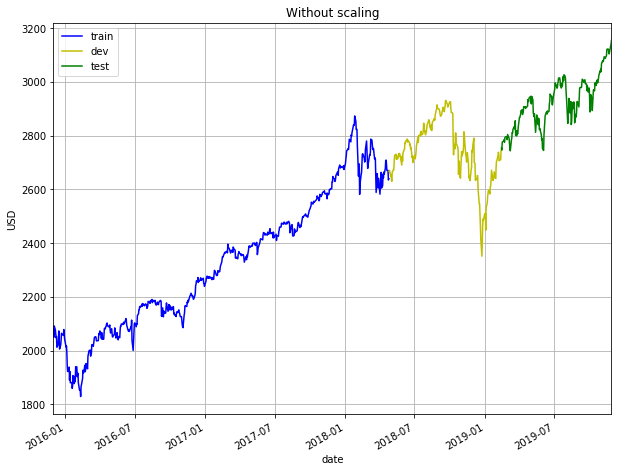

In [19]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

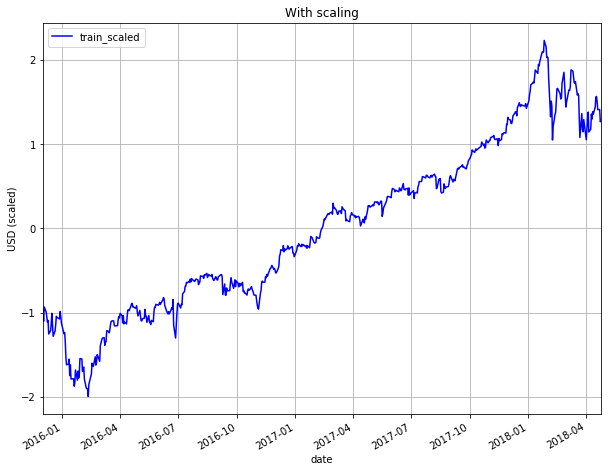

In [20]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='adj_close', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [21]:
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from src.models.m1_xgb import *
from src.conf.configuration import regress_conf

# load xgboost regression configuration
regress_conf.xgb_config_r()
regress_conf.cv_folds = None
regress_conf.early_stop_round = 1000
regress_conf.max_round = 10000

param = {'base_score':0.5, 
         'booster':'gbtree', 
         'colsample_bylevel':1,
         'colsample_bynode':1, 
         'colsample_bytree':1, 
         'gamma':0,
         'importance_type':'gain',
         'learning_rate':0.1,
         'max_delta_step':0,
         'max_depth':3,
         'min_child_weight':1,
         'missing':None,
         'n_estimators':100,
         'n_jobs':1,
         'nthread':4,
         'objective':'reg:linear',
         'random_state':0,
         'reg_alpha':0,
         'reg_lambda':1,
         'scale_pos_weight':1,
         'seed':100,
         'subsample':1, 
         'verbosity':1
        }
regress_conf.params.update(param)

xgb_m = XGBooster(regress_conf)
best_score, best_round, best_model = xgb_m.fit(X_train_scaled.values, y_train_scaled.values)


2019-12-03 13:38:41,984 - ../../../src/models/m1_xgb.py[line:96] - INFO: NonCrossValidation。。。。


[0]	train-rmse:1.0096	train-logloss:0.216213
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 1000 rounds.
[5]	train-rmse:0.608949	train-logloss:-17.1845
[10]	train-rmse:0.370204	train-logloss:-18.6181
[15]	train-rmse:0.228905	train-logloss:-19.1229
[20]	train-rmse:0.146815	train-logloss:-19.1377
[25]	train-rmse:0.101024	train-logloss:-19.1405
[30]	train-rmse:0.076568	train-logloss:-19.1506
[35]	train-rmse:0.0644	train-logloss:-19.1529
[40]	train-rmse:0.057968	train-logloss:-19.153
[45]	train-rmse:0.054175	train-logloss:-19.153
[50]	train-rmse:0.051478	train-logloss:-19.153
[55]	train-rmse:0.049506	train-logloss:-19.1531
[60]	train-rmse:0.047819	train-logloss:-19.1531
[65]	train-rmse:0.046221	train-logloss:-19.1531
[70]	train-rmse:0.04526	train-logloss:-19.1531
[75]	train-rmse:0.044366	train-logloss:-19.1531
[80]	train-rmse:0.043723	train-logloss:-19.1531
[85]	train-rmse:0.042766	train-logloss:-1

[830]	train-rmse:0.005236	train-logloss:-19.159
[835]	train-rmse:0.00516	train-logloss:-19.159
[840]	train-rmse:0.005111	train-logloss:-19.159
[845]	train-rmse:0.005051	train-logloss:-19.159
[850]	train-rmse:0.005006	train-logloss:-19.159
[855]	train-rmse:0.004933	train-logloss:-19.159
[860]	train-rmse:0.004885	train-logloss:-19.159
[865]	train-rmse:0.00483	train-logloss:-19.159
[870]	train-rmse:0.004762	train-logloss:-19.159
[875]	train-rmse:0.004691	train-logloss:-19.159
[880]	train-rmse:0.004638	train-logloss:-19.159
[885]	train-rmse:0.004576	train-logloss:-19.159
[890]	train-rmse:0.004542	train-logloss:-19.159
[895]	train-rmse:0.004486	train-logloss:-19.159
[900]	train-rmse:0.004439	train-logloss:-19.159
[905]	train-rmse:0.004396	train-logloss:-19.159
[910]	train-rmse:0.00436	train-logloss:-19.159
[915]	train-rmse:0.004296	train-logloss:-19.159
[920]	train-rmse:0.004226	train-logloss:-19.159
[925]	train-rmse:0.004179	train-logloss:-19.159
[930]	train-rmse:0.004119	train-logloss:-19

[1665]	train-rmse:0.001705	train-logloss:-19.1591
[1670]	train-rmse:0.001705	train-logloss:-19.1591
[1675]	train-rmse:0.001705	train-logloss:-19.1591
[1680]	train-rmse:0.001705	train-logloss:-19.1591
[1685]	train-rmse:0.001705	train-logloss:-19.1591
[1690]	train-rmse:0.001705	train-logloss:-19.1591
[1695]	train-rmse:0.001705	train-logloss:-19.1591
[1700]	train-rmse:0.001705	train-logloss:-19.1591
[1705]	train-rmse:0.001705	train-logloss:-19.1591
[1710]	train-rmse:0.001705	train-logloss:-19.1591
[1715]	train-rmse:0.001705	train-logloss:-19.1591
[1720]	train-rmse:0.001705	train-logloss:-19.1591
[1725]	train-rmse:0.001705	train-logloss:-19.1591
[1730]	train-rmse:0.001705	train-logloss:-19.1591
[1735]	train-rmse:0.001705	train-logloss:-19.1591
[1740]	train-rmse:0.001705	train-logloss:-19.1591
[1745]	train-rmse:0.001705	train-logloss:-19.1591
[1750]	train-rmse:0.001705	train-logloss:-19.1591
[1755]	train-rmse:0.001705	train-logloss:-19.1591
[1760]	train-rmse:0.001705	train-logloss:-19.1591


In [22]:
# Do prediction on train set
est_scaled = xgb_m.predict(best_model ,X_train_scaled.values)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.421
MAPE on train set = 0.014%


In [23]:
# # Create the model
# from xgboost import XGBRegressor

# model = XGBRegressor(seed=model_seed,
#                      n_estimators=n_estimators,
#                      max_depth=max_depth,
#                      learning_rate=learning_rate,
#                      min_child_weight=min_child_weight,
#                      subsample=subsample,
#                      colsample_bytree=colsample_bytree,
#                      colsample_bylevel=colsample_bylevel,
#                      gamma=gamma)

# # Train the regressor
# model.fit(X_train_scaled, y_train_scaled)


# Predict on train set

In [24]:
# # Do prediction on train set
# est_scaled = model.predict(X_train_scaled)
# est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# # Calculate RMSE
# print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# # Calculate MAPE
# print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

Text(0.5, 1.0, 'Without scaling')

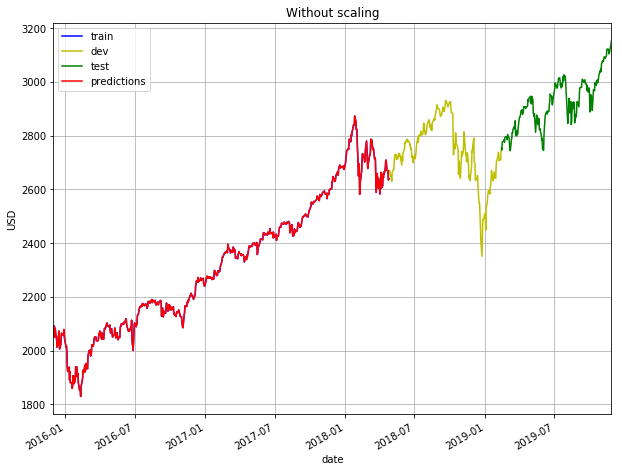

In [25]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

In [26]:
# Do prediction on test set
est_scaled = xgb_m.predict(best_model, X_cv_scaled.values)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['adj_close_std'] + cv['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 27.240
MAPE on dev set = 0.713%


/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'USD')

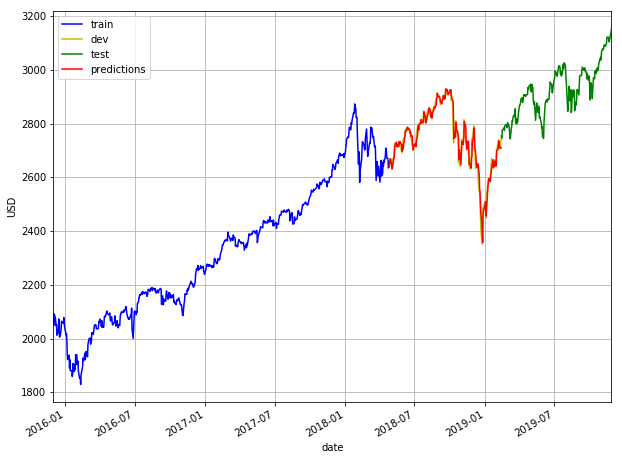

In [27]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

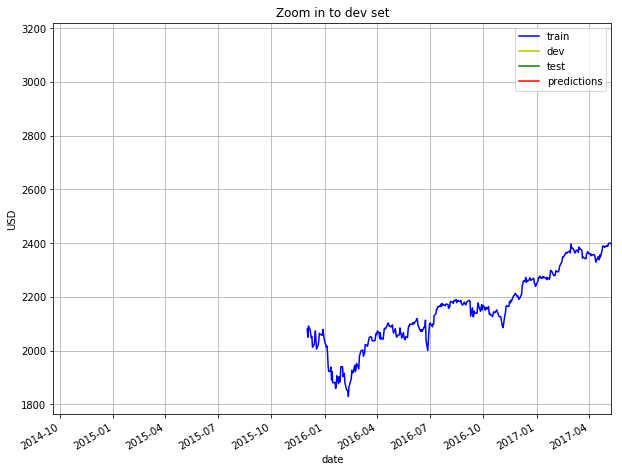

In [28]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
# ax.set_xlim([date(2018, 4, 20), date(2019, 2, 20)])

ax.set_xlim([date(2014, 9, 20), date(2017, 5, 10)])
ax.set_title("Zoom in to dev set")

The predictions capture the turn in directions with a slight lag

Importance features dominated by adj_close and volume

# Final model

In [29]:
# load xgboost regression configuration
regress_conf.xgb_config_r()
regress_conf.cv_folds = None
regress_conf.early_stop_round = 1000
regress_conf.max_round = 10000

param = {'base_score':0.5, 
         'booster':'gbtree', 
         'colsample_bylevel':1,
         'colsample_bynode':1, 
         'colsample_bytree':1, 
         'gamma':0,
         'importance_type':'gain',
         'learning_rate':0.1,
         'max_delta_step':0,
         'max_depth':3,
         'min_child_weight':1,
         'missing':None,
         'n_estimators':100,
         'n_jobs':1,
         'nthread':4,
         'objective':'reg:linear',
         'random_state':0,
         'reg_alpha':0,
         'reg_lambda':1,
         'scale_pos_weight':1,
         'seed':100,
         'subsample':1, 
         'verbosity':1
        }
regress_conf.params.update(param)

xgb_m = XGBooster(regress_conf)
best_score, best_round, best_model = xgb_m.fit(X_train_cv_scaled.values, y_train_cv_scaled.values )

2019-12-03 13:38:44,216 - ../../../src/models/m1_xgb.py[line:96] - INFO: NonCrossValidation。。。。


[0]	train-rmse:1.00956	train-logloss:0.214406
Multiple eval metrics have been passed: 'train-logloss' will be used for early stopping.

Will train until train-logloss hasn't improved in 1000 rounds.
[5]	train-rmse:0.607675	train-logloss:-15.0526
[10]	train-rmse:0.368428	train-logloss:-17.189
[15]	train-rmse:0.227372	train-logloss:-17.9637
[20]	train-rmse:0.145898	train-logloss:-18.0134
[25]	train-rmse:0.101015	train-logloss:-18.0584
[30]	train-rmse:0.077768	train-logloss:-18.0701
[35]	train-rmse:0.066176	train-logloss:-18.0699
[40]	train-rmse:0.06042	train-logloss:-18.0795
[45]	train-rmse:0.057403	train-logloss:-18.0842
[50]	train-rmse:0.055172	train-logloss:-18.0879
[55]	train-rmse:0.053587	train-logloss:-18.0969
[60]	train-rmse:0.05228	train-logloss:-18.1004
[65]	train-rmse:0.05134	train-logloss:-18.1044
[70]	train-rmse:0.05006	train-logloss:-18.117
[75]	train-rmse:0.049249	train-logloss:-18.1181
[80]	train-rmse:0.048219	train-logloss:-18.1215
[85]	train-rmse:0.047447	train-logloss:-

[830]	train-rmse:0.008861	train-logloss:-18.1661
[835]	train-rmse:0.008742	train-logloss:-18.1661
[840]	train-rmse:0.008625	train-logloss:-18.1661
[845]	train-rmse:0.008552	train-logloss:-18.1667
[850]	train-rmse:0.008464	train-logloss:-18.1667
[855]	train-rmse:0.008385	train-logloss:-18.1665
[860]	train-rmse:0.008275	train-logloss:-18.1667
[865]	train-rmse:0.008179	train-logloss:-18.1667
[870]	train-rmse:0.008093	train-logloss:-18.1667
[875]	train-rmse:0.008039	train-logloss:-18.1667
[880]	train-rmse:0.007953	train-logloss:-18.1667
[885]	train-rmse:0.007882	train-logloss:-18.1667
[890]	train-rmse:0.007804	train-logloss:-18.1667
[895]	train-rmse:0.007729	train-logloss:-18.1667
[900]	train-rmse:0.007656	train-logloss:-18.1667
[905]	train-rmse:0.007589	train-logloss:-18.1667
[910]	train-rmse:0.007523	train-logloss:-18.1667
[915]	train-rmse:0.007437	train-logloss:-18.1669
[920]	train-rmse:0.007372	train-logloss:-18.1669
[925]	train-rmse:0.00731	train-logloss:-18.1669
[930]	train-rmse:0.00

[1660]	train-rmse:0.001991	train-logloss:-18.1673
[1665]	train-rmse:0.001978	train-logloss:-18.1673
[1670]	train-rmse:0.001964	train-logloss:-18.1673
[1675]	train-rmse:0.001941	train-logloss:-18.1673
[1680]	train-rmse:0.001926	train-logloss:-18.1673
[1685]	train-rmse:0.00191	train-logloss:-18.1673
[1690]	train-rmse:0.001888	train-logloss:-18.1673
[1695]	train-rmse:0.001867	train-logloss:-18.1673
[1700]	train-rmse:0.001853	train-logloss:-18.1673
[1705]	train-rmse:0.001838	train-logloss:-18.1673
[1710]	train-rmse:0.001825	train-logloss:-18.1673
[1715]	train-rmse:0.001811	train-logloss:-18.1673
[1720]	train-rmse:0.001795	train-logloss:-18.1673
[1725]	train-rmse:0.001781	train-logloss:-18.1673
[1730]	train-rmse:0.001764	train-logloss:-18.1673
[1735]	train-rmse:0.001749	train-logloss:-18.1673
[1740]	train-rmse:0.001726	train-logloss:-18.1673
[1745]	train-rmse:0.001714	train-logloss:-18.1673
[1750]	train-rmse:0.001698	train-logloss:-18.1673
[1755]	train-rmse:0.001676	train-logloss:-18.1673
[

[2480]	train-rmse:0.001632	train-logloss:-18.1673
[2485]	train-rmse:0.001632	train-logloss:-18.1673
[2490]	train-rmse:0.001632	train-logloss:-18.1673
[2495]	train-rmse:0.001632	train-logloss:-18.1673
[2500]	train-rmse:0.001632	train-logloss:-18.1673
[2505]	train-rmse:0.001632	train-logloss:-18.1673
[2510]	train-rmse:0.001632	train-logloss:-18.1673
[2515]	train-rmse:0.001632	train-logloss:-18.1673
[2520]	train-rmse:0.001632	train-logloss:-18.1673
[2525]	train-rmse:0.001632	train-logloss:-18.1673
[2530]	train-rmse:0.001632	train-logloss:-18.1673
[2535]	train-rmse:0.001632	train-logloss:-18.1673
[2540]	train-rmse:0.001632	train-logloss:-18.1673
[2545]	train-rmse:0.001632	train-logloss:-18.1673
[2550]	train-rmse:0.001632	train-logloss:-18.1673
[2555]	train-rmse:0.001632	train-logloss:-18.1673
[2560]	train-rmse:0.001632	train-logloss:-18.1673
[2565]	train-rmse:0.001632	train-logloss:-18.1673
[2570]	train-rmse:0.001632	train-logloss:-18.1673
[2575]	train-rmse:0.001632	train-logloss:-18.1673


In [30]:
# Do prediction on train set
est_scaled = xgb_m.predict(best_model ,X_train_cv_scaled.values)
est = est_scaled * math.sqrt(scaler_train_cv.var_[0]) + scaler_train_cv.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train_cv, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train_cv, est))

RMSE on train set = 0.468
MAPE on train set = 0.015%


Text(0.5, 1.0, 'Without scaling')

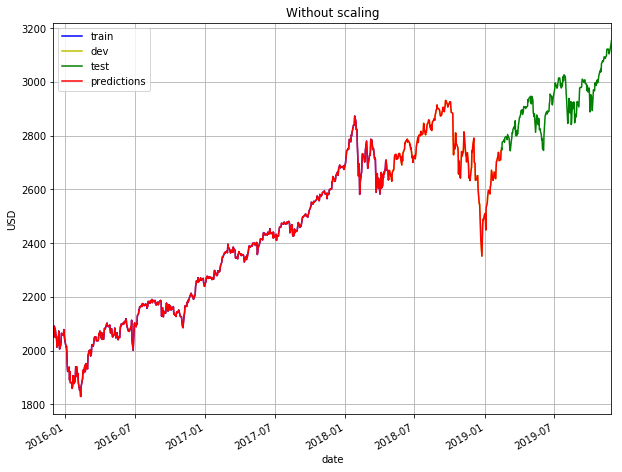

In [31]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train_cv['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

In [32]:
# Do prediction on test set
est_scaled = xgb_m.predict(best_model, X_sample_scaled.values)
test['est_scaled'] = est_scaled
test['est'] = test['est_scaled'] * test['adj_close_std'] + test['adj_close_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_sample, test['est']))
print("RMSE on test set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on test set = %0.3f%%" % mape_bef_tuning)

RMSE on test set = 22.646
MAPE on test set = 0.713%


/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0, 0.5, 'USD')

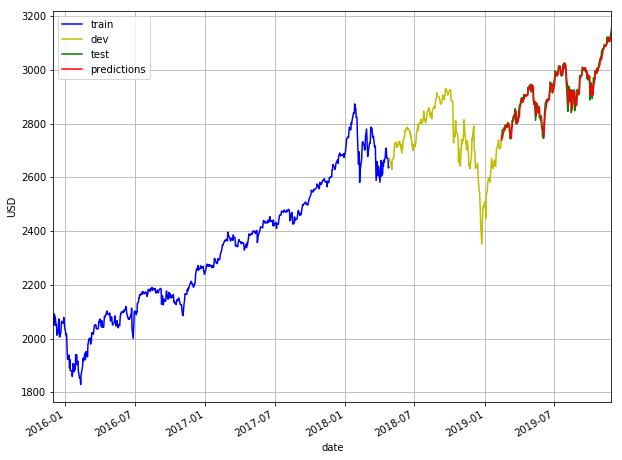

In [33]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': test['est'], 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

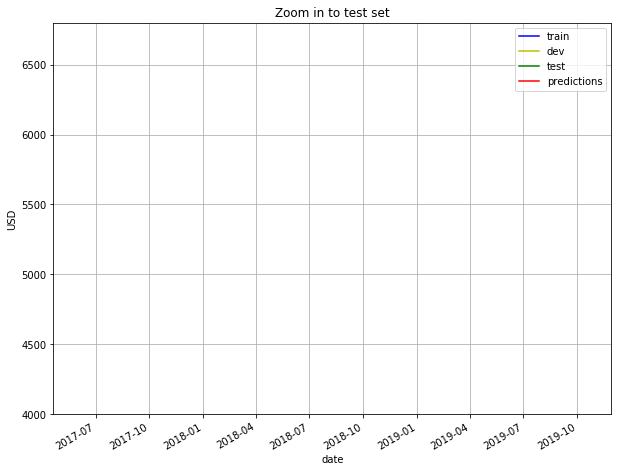

In [34]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 4, 20), date(2019, 11, 29)])
ax.set_ylim([4000, 6800])
ax.set_title("Zoom in to test set")

Similar to dev set, the predictions capture turns in direction with a slight lag

(3944, 6730)

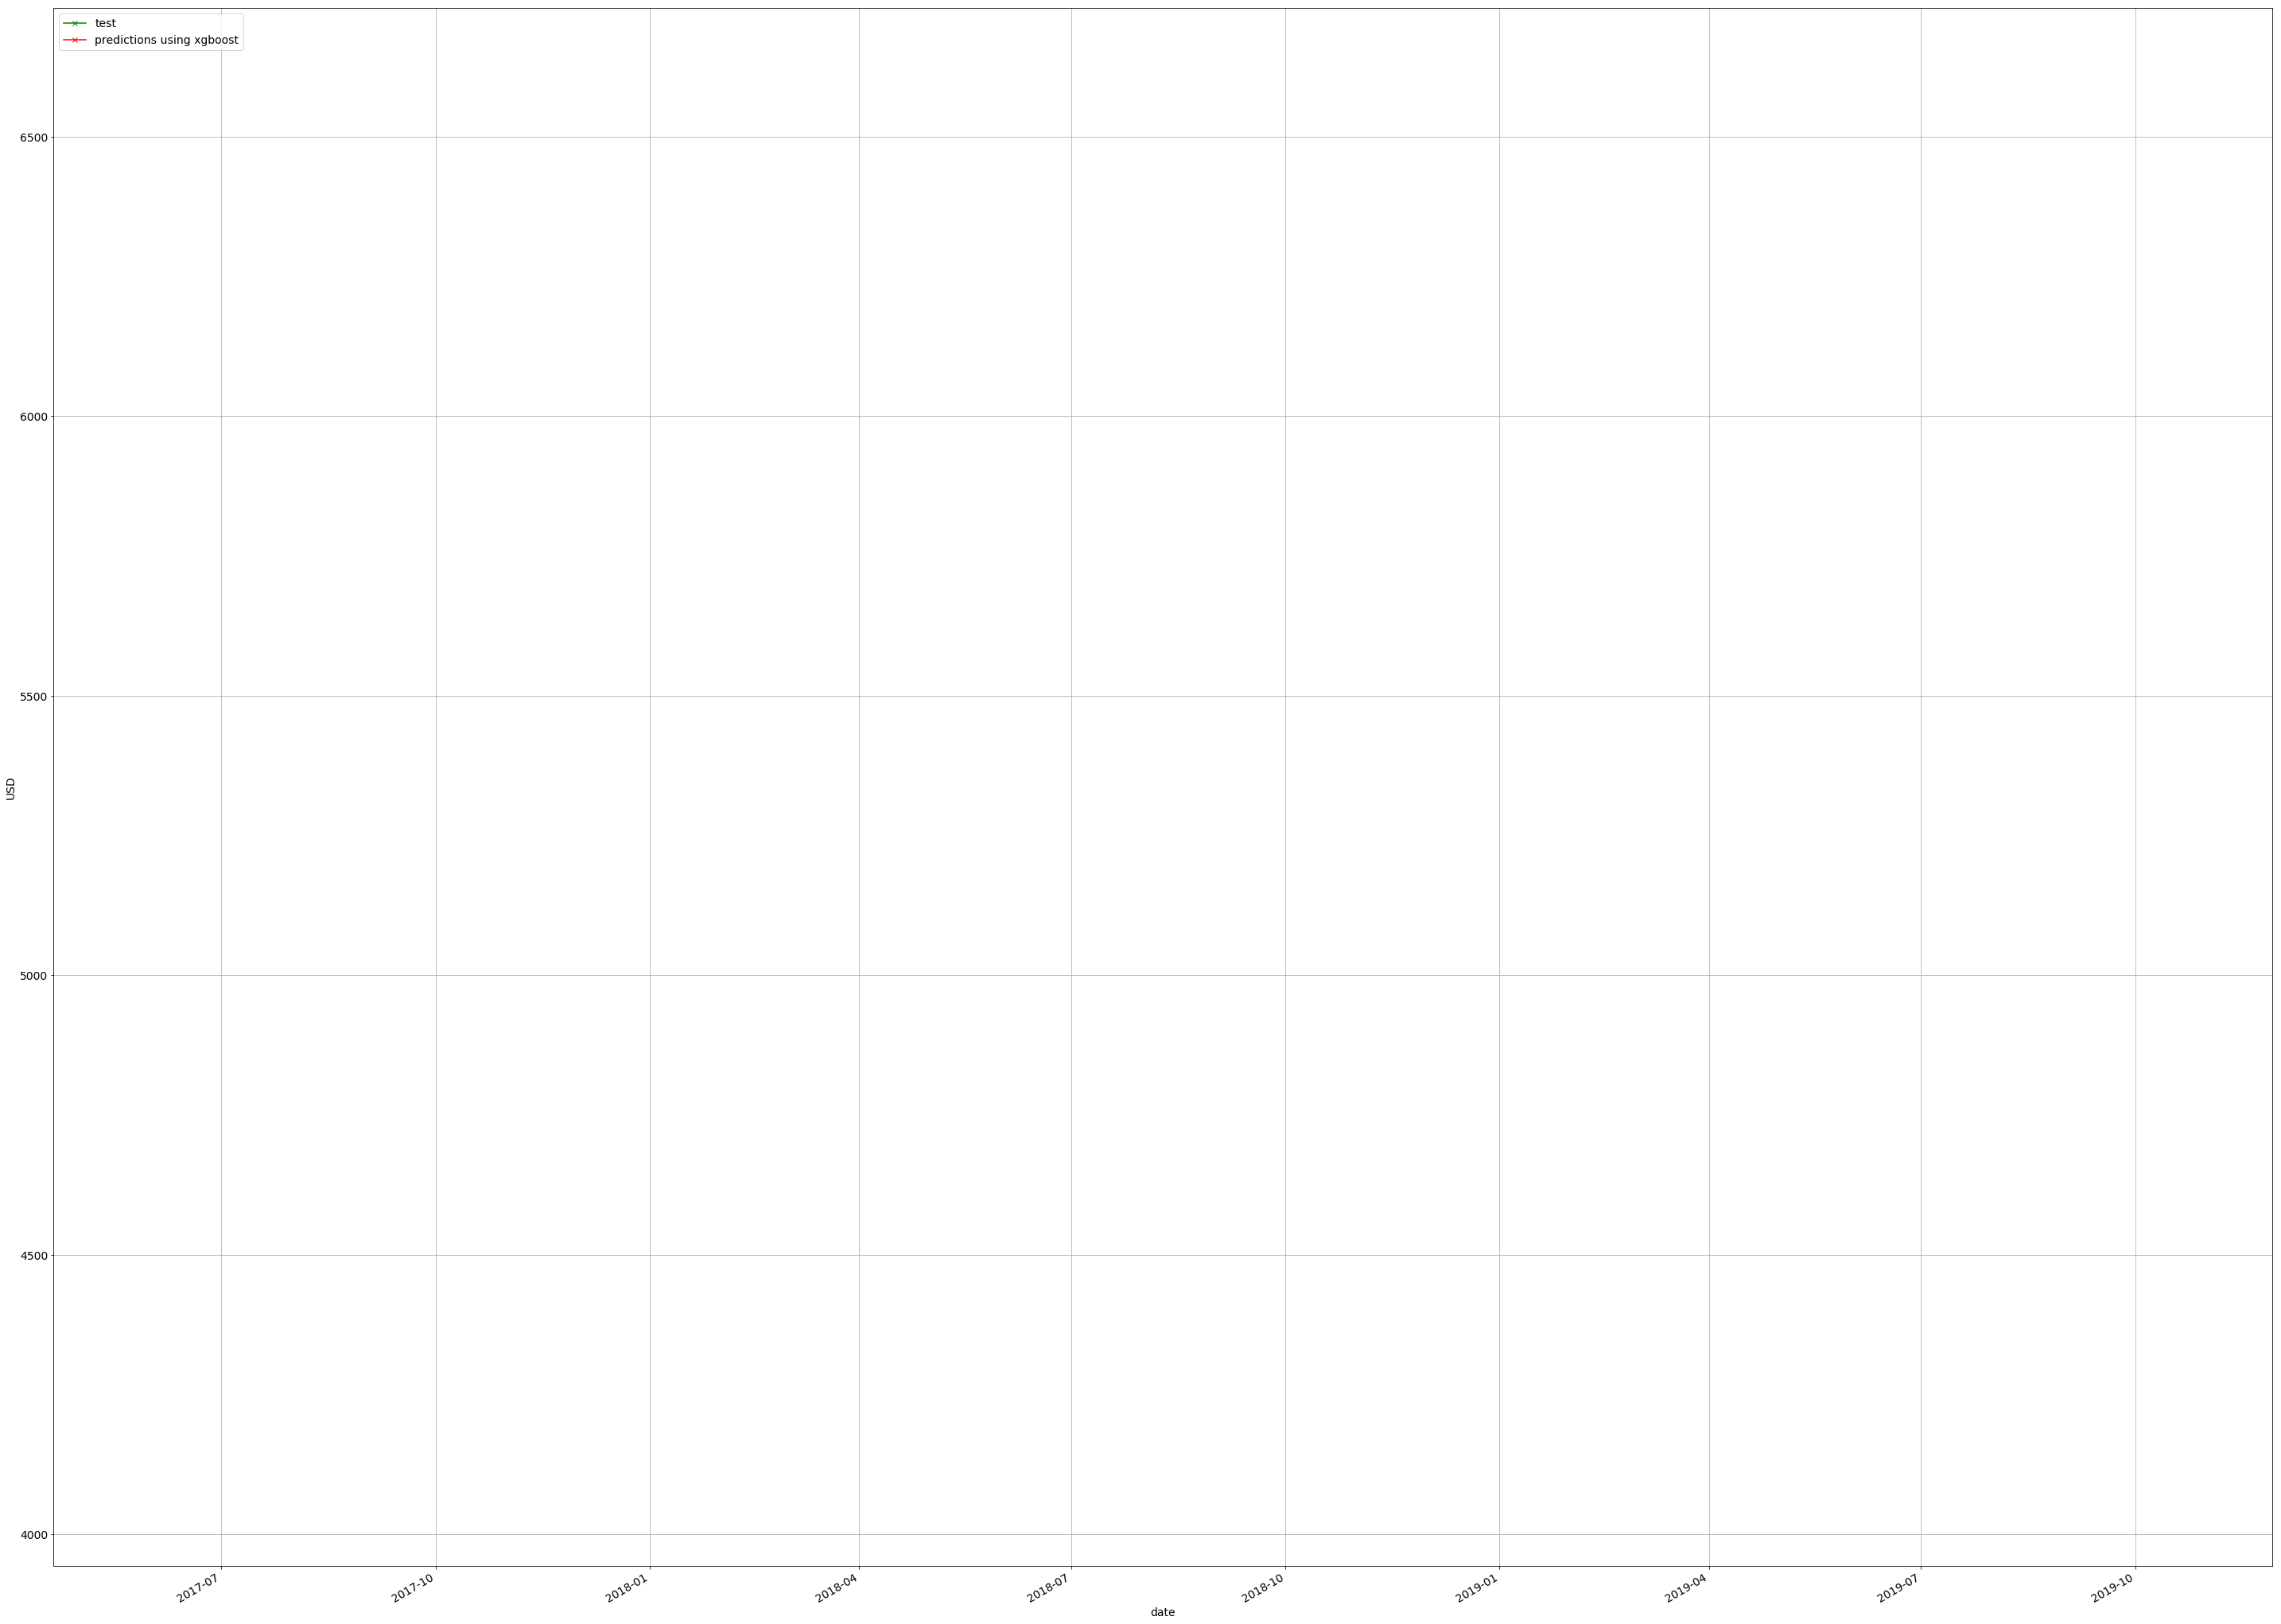

In [35]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 50, 40 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2017, 4, 20), date(2019, 11, 29)])
ax.set_ylim([3944, 6730])

In [36]:
# # Save as csv
# test_xgboost = est_df
# test_xgboost.to_csv("./out/test_xgboost.csv")

# Findings
* By scaling the features properly, we can get good results for our predictions
* RMSE and MAPE changed very little with hyperparameter tuning
* The final RMSE and MAPE for test set are 1.162 and 0.58% respectively